## Transfer learning to recognise new pictures

In [1]:
import logging
import tensorflow as tf
import keras

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
log = logging.getLogger()

%config Completer.use_jedi = False # make autocompletion works in jupyter

tf.__version__

'2.4.1'

In [2]:
import argparse 

args = argparse.Namespace()
args.train_full_folder = './data/transfer-pic/'
args.train_full_car_folder = args.train_full_folder + 'car/'
args.train_full_no_car_folder = args.train_full_car_folder + 'no-car/'
args.train_fraction = 0.8
args.seed = 101
args.batch_size = 32
args.epochs = 7

Found 84 files belonging to 2 classes.
Using 68 files for training.
Found 84 files belonging to 2 classes.
Using 16 files for validation.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0 

2021-06-17 18:56:16,331 : INFO : History keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


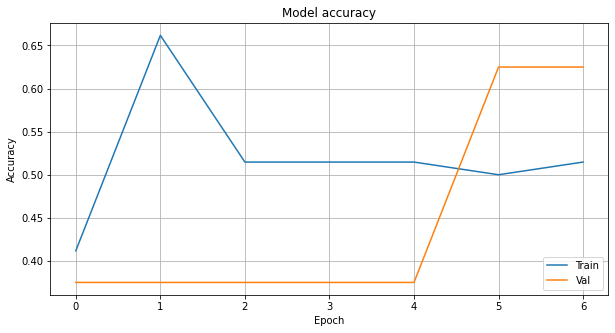

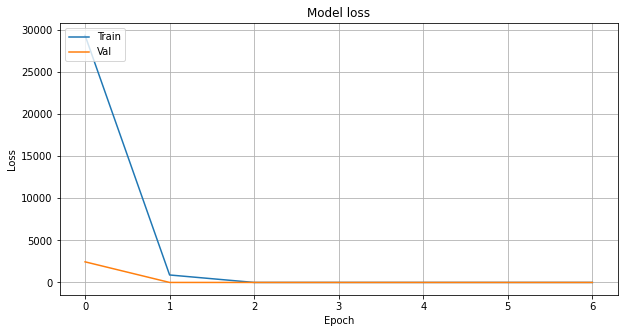

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

2021-06-17 18:59:16,408 : INFO : History keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


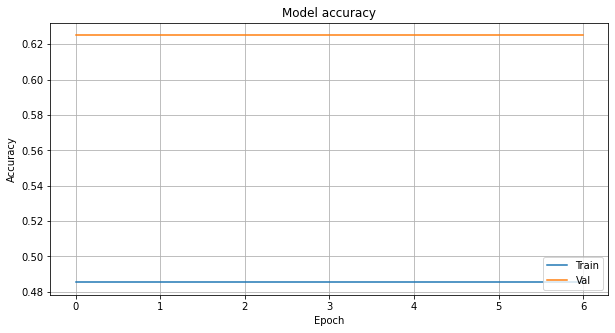

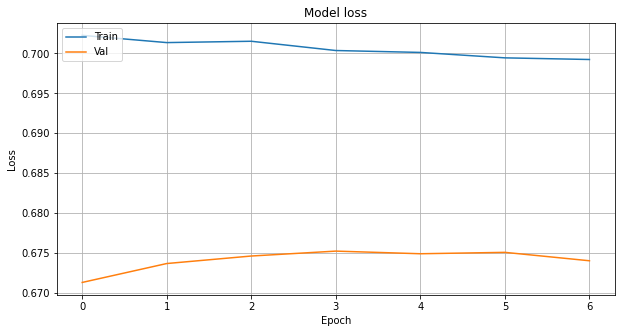

In [3]:
import matplotlib.pyplot as plt

def plot_history(history):
    log.info("History keys: %s", history.history.keys())
    # Accuracy
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(history.history['accuracy'], label='Train')
    ax.plot(history.history['val_accuracy'], label='Test')
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.grid(True)
    ax.legend(['Train', 'Val'], loc='lower right')
    
    # Loss
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.grid()
    plt.show()

def build_dataset(subset='training'):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(args.train_full_folder, 
                                                                  validation_split=1 - args.train_fraction, 
                                                                  subset=subset, seed=args.seed)
#     for d in dataset:
#         print(d)
#         break
    return dataset

def build_model():
        base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
        avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
        intermed = keras.layers.Dense(64, activation='relu')(avg)
        output = keras.layers.Dense(1, activation='sigmoid')(intermed)
        model = keras.Model(inputs=base_model.input, outputs=output)
        return base_model, model
    
    
def train(base_model, model, train_data, val_data, train_base=False, epochs=args.epochs, lr=0.2):
        for l in base_model.layers:
            l.trainable = train_base
        optimizer = keras.optimizers.SGD(lr=lr, momentum=0.9, decay=0.01)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        print(model.summary())
        history = model.fit(train_data, epochs=epochs, validation_data=val_data)
        plot_history(history)
        

def pipeline():
    train_data = build_dataset()
    val_data = build_dataset(subset='validation')
    base_model, model = build_model()
    train(base_model, model, train_data, val_data)
    train(base_model, model, train_data, val_data, train_base=True, lr=0.005)
    
pipeline()

 after training top layers loss: 0.6788 - accuracy: 0.5425 - val_loss: 0.6729 - val_accuracy: 0.6250 \
 after training all layers loss: 0.7020 - accuracy: 0.4692 - val_loss: 0.6740 - val_accuracy: 0.6250

In [5]:
# basilene

def baseline_model():
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(256, 256, 3)))
    
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.4))
    
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.4))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])
    print(model.summary())
    
    monitor='val_loss'
    early_stopping = keras.callbacks.EarlyStopping(monitor=monitor, patience=10, mode='auto', restore_best_weights=True, verbose=1)
    reduce_lr_on_plateau = keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=3, min_delta=1e-4, mode='auto', verbose=1)
    
    return model, [early_stopping, reduce_lr_on_plateau]

def baseline():
    model, callbacks = baseline_model()
    train_data = build_dataset()
    val_data = build_dataset(subset='validation')
    history = model.fit(train_data, epochs=50, validation_data=val_data, callbacks=callbacks)

baseline()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 125, 125, 64)      256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 64)       

loss: 0.0275 - accuracy: 0.9926 - val_loss: 0.6416 - val_accuracy: 0.8750